# Introduction

The goal of this project is to determine the factors that directly contribute to student success for this online program. Previous EDA showed that the distributions of numeric data did not differ between passing and failing students. One thing that was not accounted for during EDA was the weight of individual feature values. For this purpose, to reduce dimensionality, some extraneous features like 'weight' and 'is_banked' will be removed.

Additionally, the new features created like assignment duration will be solidified in the new baseline DataFrame. This DataFrame will also reduce the number of data points by aggregating observations by activity type since a chi-squared test for independence concluded that it may still be related to the final outcome.

Student, module, and assignment identities will be removed and aggregated to reduce the dimensionality for the resulting dummy variables. Since we are unable to gather more information about the unique characteristics associated with these identities, they will be treated as identifying names; which do not innately determine a student's outcome.

## Loading libraries

In [3]:
#data manipulation and visualization
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle

# preprocessing and modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from scipy import stats
from scipy import optimize
from scipy import spatial

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

## Loading statistical functions

In [5]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n
    return x, y

def pearson_r(x , y):
    """Compute Pearson correlation coefficient between two arrays."""
    corr_mat = np.corrcoef(x, y)
    return corr_mat[0, 1]

def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size = 1):
    """Draw bootstrap replicates."""
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
    return bs_replicates

def draw_bs_pairs_linreg(x, y, size = 1):
    """perform pairs bootstrap for linear regression"""
    inds = np.arange(len(x))
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    for i in range(size):
        bs_inds = np.random.choice(inds, size = len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)
    return bs_slope_reps, bs_intercept_reps

def draw_bs_pairs(x, y, func, size = 1):
    """Perform pairs bootstrap for a single statistic."""
    inds = np.arange(len(x))
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_inds = np.random.choice(inds, size = len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)
    return bs_replicates

def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
    data = np.concatenate((data1, data2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
    return perm_replicates

def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""
    diff = np.mean(data_1) - np.mean(data_2)
    return diff

def diff_frac(data_A, data_b):
    frac_A = np.sum(data_A) / len(data_A)
    frac_B = np.sum(data_B) / len(data_B)
    return frac_B - frac_A

def rmse(pred, obs):
    return np.sqrt(((pred - obs) ** 2).mean())

def mse(pred, obs):
    return ((pred - obs) ** 2).mean()

def bon_correct(alpha, n):
    return (alpha/n)

# Recleaning data

Even after EDA, the data needs to be reevaluated based on the insights made during EDA.

Goals:
* Solidify the transformation of how long students took to complete each assessment.
    * Since all dates are relative to the start of either the course or the module, we can easily convert the feature 'date_submitted' to 'duration'.
    * It would be interesting to see how student outcomes relate to how long they took to complete an assignment.
* Aggregate number of clicks per day to quantify student interactions with the material
* Drop 'weight', 'is_banked', 'id_site', 'code_module', and 'code_presentation'.
    * Innate identity of the modules, sites, and students requires too many assumptions to account for our analyses.
    * 'weight' is a characteristic of the assignment which falls outside of the scope of this study since I am primarily concerned with features directly related to the students.
    * 'is_banked' is more of an administrative feature that would highlight whether an assignment was transferred from a previous presentation. Because we do not know the characteristics of each assignment, we will consider the assignments independently.
    * 'date_registration' will be left as is since having longer to complete the course may impact whether they pass or failed
* Aggregate numerical features by 'id_student', 'id_asessment', and 'activity_type'

## Reloading the data

We are still operating off the csv we wrangled for EDA. To track the transformation stages, I will be storing the new DataFrames as 'df#'.

In [9]:
df0 = pd.read_csv('eda_stage.csv')

In [10]:
df0.head()

,id_student,gender,disability,age_band,region,imd_band,highest_education,id_site,code_module,code_presentation,id_assessment,date_registration,num_of_prev_attempts,final_result,studied_credits,date_submitted,score,assessment_type,module_presentation_length,weight,is_banked,activity_type,date,sum_click
0,2412002,Male,No,35-55,South West Region,50-60%,Lower Than A Level,546652,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,No,forumng,19,1
1,2412002,Male,No,35-55,South West Region,50-60%,Lower Than A Level,546652,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,No,forumng,19,1
2,2412002,Male,No,35-55,South West Region,50-60%,Lower Than A Level,546614,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,No,homepage,19,10
3,2412002,Male,No,35-55,South West Region,50-60%,Lower Than A Level,546876,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,No,subpage,19,2
4,2412002,Male,No,35-55,South West Region,50-60%,Lower Than A Level,546871,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,No,subpage,19,1


In [11]:
df0.shape

(534781, 24)

In [12]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534781 entries, 0 to 534780
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   id_student                  534781 non-null  int64 
 1   gender                      534781 non-null  object
 2   disability                  534781 non-null  object
 3   age_band                    534781 non-null  object
 4   region                      534781 non-null  object
 5   imd_band                    534781 non-null  object
 6   highest_education           534781 non-null  object
 7   id_site                     534781 non-null  int64 
 8   code_module                 534781 non-null  object
 9   code_presentation           534781 non-null  object
 10  id_assessment               534781 non-null  int64 
 11  date_registration           534781 non-null  int64 
 12  num_of_prev_attempts        534781 non-null  int64 
 13  final_result                5

In [13]:
df0.describe()

,id_student,id_site,id_assessment,date_registration,num_of_prev_attempts,studied_credits,date_submitted,score,module_presentation_length,weight,date,sum_click
count,5.347810e+05,5.347810e+05,534781.000000,534781.000000,534781.000000,534781.000000,534781.000000,534781.000000,534781.000000,534781.000000,534781.000000,534781.000000
mean,7.127787e+05,7.263949e+05,28436.897968,-64.392058,0.162405,81.699219,127.952180,76.409983,254.948194,9.646102,142.566363,4.769915
std,5.675385e+05,1.314079e+05,8205.247185,46.124150,0.471151,39.871460,75.137527,17.549058,13.819019,10.782572,79.696081,11.630602
min,6.516000e+03,5.267210e+05,1752.000000,-310.000000,0.000000,30.000000,-8.000000,0.000000,234.000000,0.000000,12.000000,1.000000
25%,4.974100e+05,5.510670e+05,24295.000000,-92.000000,0.000000,60.000000,54.000000,67.000000,240.000000,0.000000,67.000000,1.000000
50%,5.815520e+05,7.169890e+05,34861.000000,-52.000000,0.000000,60.000000,131.000000,80.000000,261.000000,7.000000,149.000000,2.000000
75%,6.346360e+05,8.325670e+05,34888.000000,-28.000000,0.000000,120.000000,201.000000,89.000000,268.000000,18.000000,222.000000,4.000000
max,2.698588e+06,1.046237e+06,37443.000000,101.000000,6.000000,630.000000,285.000000,100.000000,269.000000,100.000000,261.000000,655.000000


In [14]:
numeric_names = ['studied_credits', 'weight', 'sum_click', 'date_registration']

In [15]:
df1 = df0.copy()
for col in numeric_names:
    lower = df1[col].quantile(0.025)
    upper = df1[col].quantile(0.975)
    df1 = df1[(df1[col] >= lower) & (df1[col] <= upper)]

df1.describe()

,id_student,id_site,id_assessment,date_registration,num_of_prev_attempts,studied_credits,date_submitted,score,module_presentation_length,weight,date,sum_click
count,4.835370e+05,4.835370e+05,483537.000000,483537.000000,483537.000000,483537.000000,483537.000000,483537.000000,483537.000000,483537.000000,483537.000000,483537.000000
mean,7.119907e+05,7.249904e+05,28575.109431,-62.346881,0.154559,78.875898,125.885227,76.641467,254.939765,9.343591,140.691844,3.305985
std,5.644772e+05,1.311824e+05,8053.262105,39.911590,0.459023,33.088866,74.861275,17.501694,13.847519,9.595551,79.781176,4.182204
min,6.516000e+03,5.267210e+05,1752.000000,-172.000000,0.000000,30.000000,-8.000000,0.000000,234.000000,0.000000,12.000000,1.000000
25%,5.013360e+05,5.510410e+05,24296.000000,-88.000000,0.000000,60.000000,53.000000,67.000000,240.000000,0.000000,54.000000,1.000000
50%,5.826700e+05,7.167450e+05,34861.000000,-52.000000,0.000000,60.000000,128.000000,80.000000,261.000000,7.000000,144.000000,2.000000
75%,6.344040e+05,8.325650e+05,34888.000000,-29.000000,0.000000,120.000000,199.000000,89.000000,268.000000,18.000000,222.000000,4.000000
max,2.698535e+06,1.019025e+06,37443.000000,-10.000000,6.000000,180.000000,243.000000,100.000000,269.000000,28.000000,241.000000,29.000000


In [16]:
df1.shape

(483537, 24)

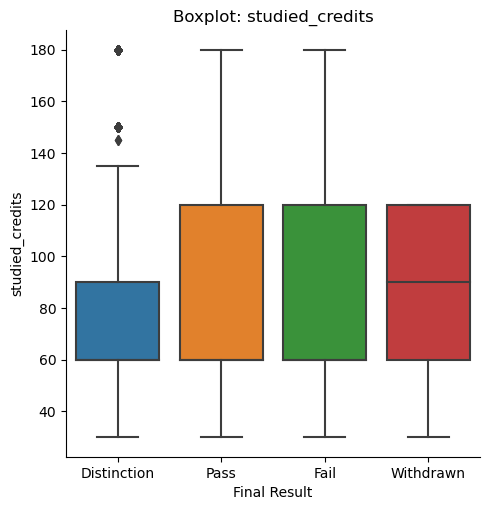

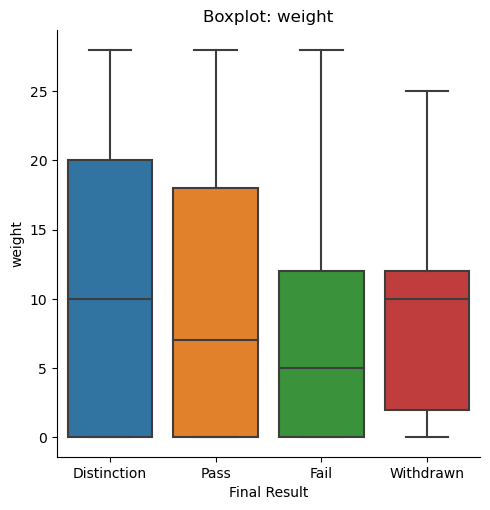

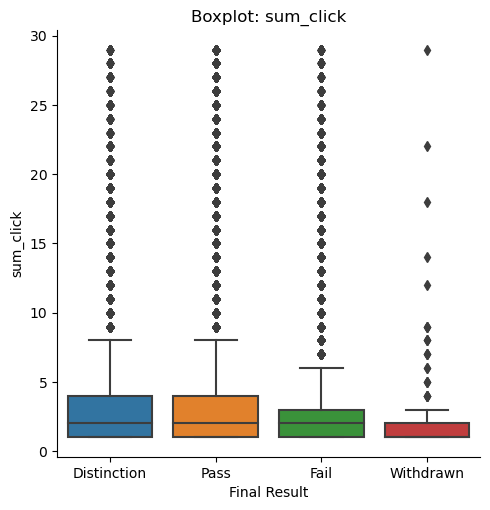

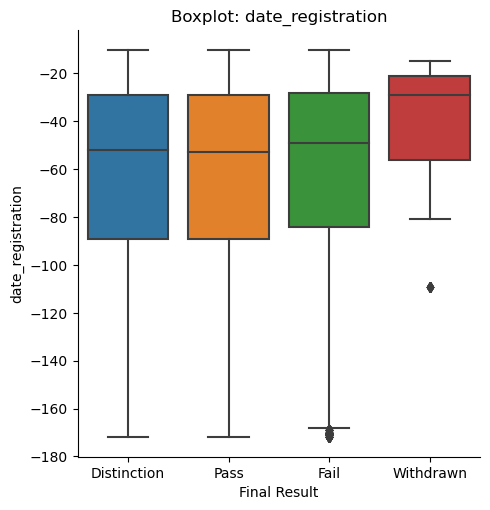

In [17]:
for col in numeric_names:
    _ = sns.catplot(x = 'final_result', y = col, data = df1, kind = 'box')
    _ = plt.xlabel('Final Result')
    _ = plt.ylabel(f'{col}')
    _ = plt.title(f'Boxplot: {col}')
    plt.show()

## Categorical binaries

Since there are only two values inputted for 'disability' and 'gender', the two will be binarily encoded.

For 'disability', the absence of a disability (No) will be encoded to 0, where as the presence (Yes) will be encoded to 1.
For 'gender', Male was chosen arbitrarily to be encoded as 0 and Female was chosen to be 1.

In [20]:
df2 = df1.copy()
df2['disability'].replace({'No': 0, 'Yes': 1}, inplace = True)
df2['gender'].replace({'Male': 0, 'Female': 1}, inplace = True)

## Highest Education

Highest education in this instance may be considered ordinal since the various education levels may indicate different levels of investment or access with academic resources. Although all education levels should be treated equally successful in their respective categories, for these purposes of interacting in online academic programs, we cannot rule out prior experience with academic resources as confounding factor.

Below is a translation of the academic levels in their order from least academic exposure to most:

1. No formal quals: Did not complete any level of formal education like highschool
2. Lower Than A Level: About equivalent to highschool but not enough for an Associates degree
3. A level or Equivalent: About equivalent to early Bachelors degree but not completed
4. HE Qualification: Bachelor's degree
5. Post Graduate Qualification: Postgraduate certificates, Masters, PhD

In [23]:
df2['highest_education'].value_counts()

highest_education
A Level or Equivalent          228115
Lower Than A Level             169291
HE Qualification                80119
No Formal quals                  3200
Post Graduate Qualification      2812
Name: count, dtype: int64

In [24]:
edu_levels = {'No Formal quals': 1,
              'Lower Than A Level': 2,
              'A Level or Equivalent': 3,
              'HE Qualification': 4,
              'Post Graduate Qualification': 5
             }
df3 = df2.copy()
df3['highest_education'] = df3['highest_education'].replace(edu_levels)
df3['highest_education'].value_counts()

highest_education
3    228115
2    169291
4     80119
1      3200
5      2812
Name: count, dtype: int64

## Aggregates

The two of the top 10 predicting variables during the RandomForest exploration were 'date' and 'sum_click'.

While 'date' is a duration length relative to the start of the module, it only serves as a marker for each day of interaction with each activity the students interacted with per assessment; making it more of a categorical feature than numeric. For this reason, 'date' will be aggregated as a count of the number of days interacting with the material. This may quantify the level interaction with each activity type.

Similarly, 'sum_click' is the number of clicks per recorded day. Since the reference date will be removed by the aggregation, 'sum_click' will be aggregated to the total number of clicks per activity to retain the nature of the feature.

In [26]:
new_click_cols = df3.groupby(['id_assessment', 'id_student', 'activity_type']).agg(
    days_active = ('date', 'count'),
    total_clicks = ('sum_click', 'sum')
)
new_clicks = new_click_cols.reset_index()

In [27]:
df4 = df3.merge(new_clicks, on = ['id_assessment', 'id_student', 'activity_type'])

### Assessment Duration

The 'date_submitted' column is a numeric feature that indicates the date the assessment was submitted since the start of the module. Unlike 'date' which served as a reference marker for interactions, this date can be used as more of a duration than marker. Changing the name is more for the user experience to avoid future confusion.

In [29]:
df5 = df4.rename(columns = {'date_submitted': 'assessment_duration'})

## Dropping redundancies and columns

Since 'date' and 'sum_click' both have already been aggregated earlier in df 4, these two columns will be dropped. Additionally, 'is_banked' is more of an administrative feature that is neither a direct identifier of the student nor is it the direct result of the students' actions. Analyzing whether or not an assessment of the student's will reduce the focus in the model away from the more likely predictors of student success for this program. Lastly, 'weight', 'code_module', 'code_presentation', and 'id_site' are all characteristics of 'id_assessment'. These characteristic features will be dropped since they will still have representation through the 'id_assessment'. Although 'module_presentation_length' is a numeric feature, it will be removed from consideration for similar reasons as 'weight'; also duration per assessment is already being considered in 'assessment_duration'.

In [31]:
df6 = df5.drop(columns = ['date', 'sum_click', 'is_banked', 'weight', 'module_presentation_length', 'code_module', 'code_presentation', 'id_site', 'assessment_type'])

In [32]:
df7 = df6.drop_duplicates()

## Identifier

There are now two unique categorical identifiers: 'id_student' and 'id_assessment'. Both features serve no numeric purpose and only distinguish sets of data from one another. The purpose of this study is to identify the features most important to student success through interaction with the material or demographic information. Aggregate features will be created per student to control for the assessment identity.

### Features to aggregate
Not all numeric features (e.g. 'num_of_prev_attempts') need to be aggregated since they are specific identifiers that do not change between 'id_student', 'id_assessment', or 'activity_type'.

Aggregating features
* 'score': average score per assessment
* 'days_active': average days activity per activity_type per assessment, total number of days active per activity type
* 'total_clicks': average total clicks per activity_type per assessment, total number of clicks per activity type
* 'assessment_duration': average time taken per assessment, max_time taken per assessment

### Score and Assessment Duration

In [36]:
assess_col = df7.groupby(['id_student']).agg(
    mean_score = ('score', 'mean'),
    mean_assessment_length = ('assessment_duration', 'mean'),
    max_assessment_length = ('assessment_duration', 'max')
)
assess_col.reset_index(inplace = True)

### Activity levels

In [38]:
act_col = df7.groupby(['id_student', 'activity_type']).agg(
    mean_active = ('days_active', 'mean'),
    total_active = ('days_active', 'sum'),
    mean_clicks = ('total_clicks', 'mean'),
    clicks = ('total_clicks', 'sum')
)
act_col.reset_index(inplace = True)

### Merging and Dropping

In [40]:
df8 = df7.merge(assess_col, on = 'id_student') \
    .merge(act_col, on = ['id_student', 'activity_type'])

In [41]:
df9 = df8.drop(columns = ['id_assessment', 'days_active', 'total_clicks', 'score', 'assessment_duration'])

In [42]:
df10 = df9.drop_duplicates()
df10.shape

(72305, 19)

# Encoding

Now that that data has been aggregated and cleaned, the categorical variables need to be encoded. Some of the features were previously handled, however 'age_band', 'region', 'imd_band', and 'activity_type' still need to be encoded. The features 'age_band' and 'imd_band' are ordinal so they can be encoded based on their value levels starting at 1. The remaining two will need to be OneHot Encoded.

In [44]:
df11 = df10.copy()
df11['age_band'].replace({'0-35': 1, '35-55': 2, '55<=': 3}, inplace = True)

In [45]:
df11['imd_band'].replace({'50-60%': 5,
                          '10-20%': 1,
                          '40-50%': 4,
                          '60-70%': 6,
                          '90-100%': 9,
                          '30-40%': 3,
                          '70-80%': 7,
                          '20-30%': 2,
                          '0-10%': 0,
                          '80-90%': 8},
                         inplace = True
                        )

#### Update as of 06/23/24

Activity and regions have been serverly undervalued, therefore, I have found a encoding technique used in Kaggle competitions that encode values using their counts to simulate their weights. I do not want their encdings to lessen their weights like it has shown so far with my initial rf and in trying to model during 28.3.

https://www.youtube.com/watch?v=MPnNC6kkNC4

ohe = OneHotEncoder()
ohe_cols = ohe.fit_transform(df11[['region', 'activity_type']])
feat_names = ohe.get_feature_names_out(['region', 'activity_type'])
ohe_df = pd.DataFrame(ohe_cols.toarray(), columns = feat_names)
df12 = pd.concat([df11, ohe_df], axis = 1)
df13 = df12.drop(columns = ['region', 'activity_type'])

In [47]:
region_map = df11['region'].value_counts().to_dict()
activity_map = df11['activity_type'].value_counts().to_dict()

In [48]:
df12 = df11.copy()
df12['region'] = df12['region'].map(region_map)
df12['activity_type'] = df12['activity_type'].map(activity_map)

In [49]:
with open('region_map.pkl', 'wb') as f:
    pickle.dump(region_map, f)

with open('activity_map.pkl', 'wb') as file:
    pickle.dump(activity_map, file)

In [50]:
df14 = df12.dropna()

In [51]:
bool_col = df14.filter(regex = 'region_*|activity_type_*').columns

In [52]:
df15 = df14.astype(
    {
        'id_student': 'int',
        'gender': 'int',
        'disability': 'int',
        'age_band': 'int',
        'imd_band': 'int',
        'highest_education': 'int',
        'date_registration': 'int',
        'num_of_prev_attempts': 'int',
        'studied_credits': 'int'
    }
)
for col in bool_col:
    df15[col] = df15[col].astype('int')

In [53]:
df = df15.reset_index(drop = True)
df.shape

(72305, 19)

In [98]:
df.to_csv('capstone_2_modeling_v2.csv')

# Splitting the Data

Now that the data has been encoded, it can now be split into its respective x and y variables. The 'final_result' feature was left untouched since it was the response variable to all the other features. For x data, 'id_student' will be dropped since it serves as more of a categorical variable.

Since the data points were originally ordered by assessment and student, I will need to shuffle the train_test to make sure students at the bottom of the df do not unnecessarily get cut.

In [56]:
x = df.drop(columns = ['id_student', 'final_result'])
y = df[['final_result']]

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 6022, stratify = y, test_size = 0.25, shuffle = True)

# Scaling

Despite encoding, a few columns are still beyond a comparable scope of eachother. A StandardScaler will be applied to ensure that all values are comparable.

In [58]:
scaler = Normalizer()
scaler_model = scaler.fit(x_train)

In [59]:
x_train_scale = scaler_model.transform(x_train)
x_test_scale = scaler_model.transform(x_test)

# Conclusion

The data has been cleaned, encoded, and split into training and testing sets. From here the modeling required is most likely KNN, decision tree analysis, and/or logistic regression to determine the predicting features.